In [47]:
import pandas as pd 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import f1_score
warnings.filterwarnings("ignore")
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
dic_class = {0: 'healthy', 1: 'not healthy', 2: 'unknown'}
dic_class_cat = {'healthy': 0, 'not healthy': 1, 'unknown': 2}

df = pd.read_csv(r'.\voice-audios\dataset_audio_total.csv')
print('columnas dataset total: ', df.columns.to_list())
nombres_significativos6 =   ['MFCC_2_mean', 'spectral_flatness_mean', 'zcr_mean', 'hnr_librosa', 'spectral_centroid_mean', 'MFCC_1_mean']
nombres_significativos =   ['MFCC_2_mean', 'spectral_flatness_mean', 'zcr_mean', 'hnr_librosa', 'spectral_centroid_mean', 'MFCC_1_mean', 'MFCC_13_std', 'MFCC_12_std', 'MFCC_11_std', 'MFCC_2_std', 'MFCC_7_mean', 'MFCC_13_mean', 'MFCC_3_mean', 'MFCC_4_mean', 'MFCC_11_mean', 'MFCC_10_std', 'MFCC_9_std', 'spectral_centroid_std', 'MFCC_1_std', 'MFCC_9_mean', 'MFCC_3_std', 'MFCC_5_mean']
nombres = ['MFCC_1_mean', 'MFCC_1_std', 'MFCC_2_mean', 'MFCC_2_std', 'MFCC_3_mean', 'MFCC_3_std', 'MFCC_4_mean', 'MFCC_4_std', 'MFCC_5_mean', 'MFCC_5_std', 'MFCC_6_mean', 'MFCC_6_std', 'MFCC_7_mean', 'MFCC_7_std', 'MFCC_8_mean', 'MFCC_8_std', 'MFCC_9_mean', 'MFCC_9_std', 'MFCC_10_mean', 'MFCC_10_std', 'MFCC_11_mean', 'MFCC_11_std', 'MFCC_12_mean', 'MFCC_12_std', 'MFCC_13_mean', 'MFCC_13_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_flatness_mean', 'zcr_mean', 'hnr_librosa']

cols_to_convert = df.columns.difference(['file_name'])
df[cols_to_convert] = df[cols_to_convert].apply(pd.to_numeric, errors='coerce')

voiced_mask = df['file_name'].str.startswith('voice')
print(f"Filas VOICED eliminadas: {voiced_mask.sum()}")

df = df[~voiced_mask].reset_index(drop=True)

X, y = df, df['clase']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

columnas dataset total:  ['file_name', 'MFCC_1_mean', 'MFCC_1_std', 'MFCC_2_mean', 'MFCC_2_std', 'MFCC_3_mean', 'MFCC_3_std', 'MFCC_4_mean', 'MFCC_4_std', 'MFCC_5_mean', 'MFCC_5_std', 'MFCC_6_mean', 'MFCC_6_std', 'MFCC_7_mean', 'MFCC_7_std', 'MFCC_8_mean', 'MFCC_8_std', 'MFCC_9_mean', 'MFCC_9_std', 'MFCC_10_mean', 'MFCC_10_std', 'MFCC_11_mean', 'MFCC_11_std', 'MFCC_12_mean', 'MFCC_12_std', 'MFCC_13_mean', 'MFCC_13_std', 'spectral_centroid_mean', 'spectral_centroid_std', 'spectral_flatness_mean', 'zcr_mean', 'hnr_librosa', 'clase']
Filas VOICED eliminadas: 208


In [48]:

X_train, X_test, y_train, y_test = X_train[nombres_significativos6], X_test[nombres_significativos6], y_train, y_test

def balancear(X, y):
    df = X.copy()
    df['clase'] = y

    df_min = df[df['clase'] == 1]
    df_maj = df[df['clase'] == 0]

    df_min_upsampled = resample(
        df_min,
        replace=True,
        n_samples=len(df_maj),
        random_state=42
    )

    df_balanced = pd.concat([df_maj, df_min_upsampled])
    df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

    X_bal = df_balanced.drop(columns='clase')
    y_bal = df_balanced['clase']

    return X_bal, y_bal


X_train, y_train = balancear(X_train, y_train)


In [50]:
from tensorflow.keras.optimizers import Adam

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid') 
])

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0005)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

# Evaluación
y_pred_proba = model.predict(X_test_scaled)
y_pred = (y_pred_proba > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Macro:", f1_score(y_test, y_pred, average='macro'))
print("Reporte completo:\n", classification_report(y_test, y_pred))


Epoch 1/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6926 - loss: 0.5933 - val_accuracy: 0.7616 - val_loss: 0.4691
Epoch 2/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7701 - loss: 0.5051 - val_accuracy: 0.7996 - val_loss: 0.4539
Epoch 3/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7824 - loss: 0.4888 - val_accuracy: 0.7941 - val_loss: 0.4494
Epoch 4/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7734 - loss: 0.5022 - val_accuracy: 0.8061 - val_loss: 0.4489
Epoch 5/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7877 - loss: 0.4697 - val_accuracy: 0.8061 - val_loss: 0.4444
Epoch 6/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7828 - loss: 0.4849 - val_accuracy: 0.8052 - val_loss: 0.4402
Epoch 7/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7902 - loss: 0.4691 - val_accuracy: 0.8080 - val_loss: 0.4395
Epoch 8/100
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7906 - loss: 0.4732 - val_accu

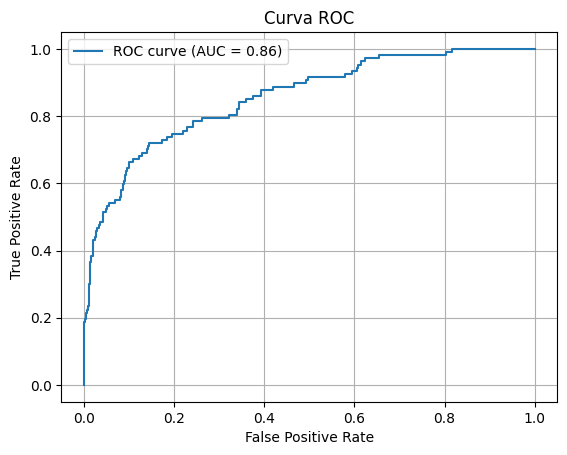

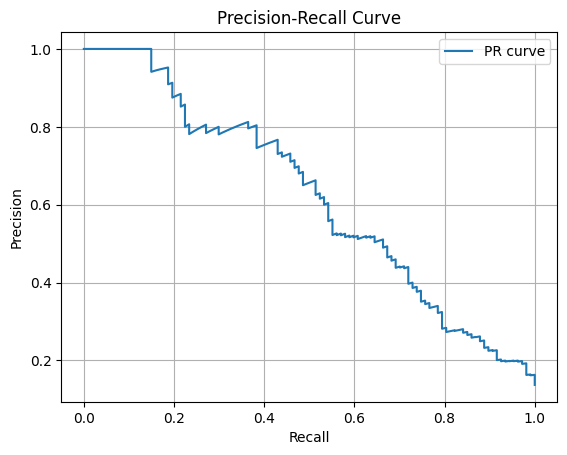

In [51]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)

plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc(fpr, tpr)))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC')
plt.legend()
plt.grid()
plt.show()

plt.plot(recall, precision, label='PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid()
plt.show()

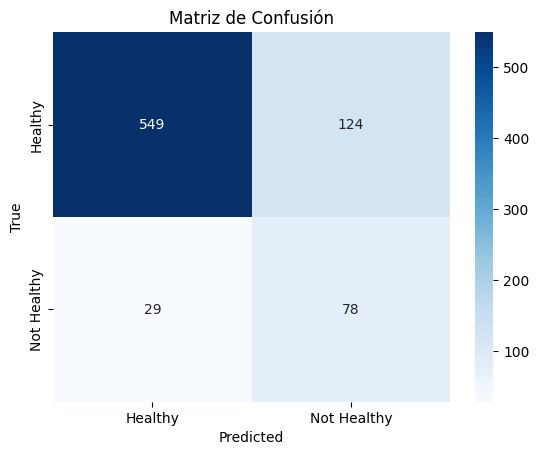

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Not Healthy'],
            yticklabels=['Healthy', 'Not Healthy'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Matriz de Confusión")
plt.show()


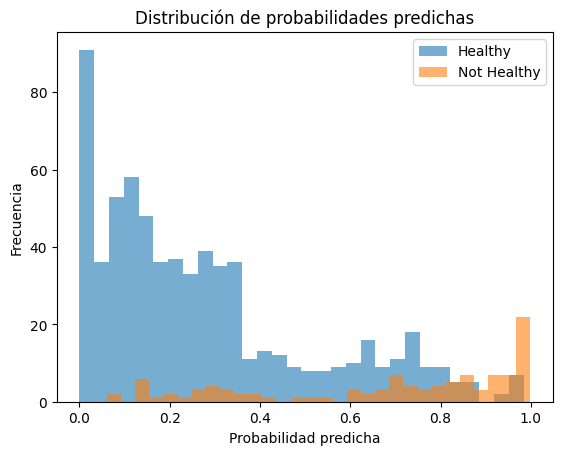

In [53]:
plt.hist(y_pred_proba[y_test == 0], bins=30, alpha=0.6, label='Healthy')
plt.hist(y_pred_proba[y_test == 1], bins=30, alpha=0.6, label='Not Healthy')
plt.xlabel("Probabilidad predicha")
plt.ylabel("Frecuencia")
plt.title("Distribución de probabilidades predichas")
plt.legend()
plt.show()
